## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make the notebook executable on google colab
if 'google.colab' in str(get_ipython()):
    # install package
    try:
      import gsemantique
    except ImportError:
      !git clone https://github.com/fkroeber/gsemantique.git
      !cd gsemantique && pip install .
    # change working directory
    demo_dir = "gsemantique/demo"
    import os
    if not os.getcwd().endswith(demo_dir):
      os.chdir(demo_dir)
else:
    # get the logger to investigate the logs 
    import logging
    import sys
    logger = logging.getLogger("gsemantique.data.search")
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    logger.addHandler(stream_handler)

In [3]:
# general imports
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rioxarray as rxr
import shutil
import warnings
from shapely.geometry import box

# semantique imports
import gsemantique as gsq
import semantique as sq
from gsemantique.data.datasets import DatasetCatalog
from gsemantique.data.download import Downloader
from gsemantique.data.search import Finder
from gsemantique.process.scaling import TileHandler, TileHandlerParallel
from gsemantique.process.utils import update_na, change_dtype

In [4]:
# get gsemantiques layout file
package_dir = os.path.split(gsq.__file__)[0]
layout_path = os.path.join(package_dir, "data", "layout.json")

# load data catalog
ds_catalog = DatasetCatalog()
ds_catalog.load()

## Intro

Frequently, clouds are obscuring the actual entities of interest, i.e the Earth's surface. Therefore, filtering data for scenes with minimal cloud coverage is a common preprocessing step in many EO processing workflows. This notebook showcases how clouds can be filtered within semantic EO data cubes. 

Specifically, the notebook aims to demonstrate how the dedicated exclusion of clouds at the pixel-level using semantic querying leads to superior results in the downstream task of creating cloud-free composites when comparing this to a common alternative approach, the so-called median composite. In this conventional approach, the median value of a timeseries is used to likely capture a cloud-free one (since clouds are very bright and therefore most likely above the median). As such, the median compositing technqiue makes indirect assumptions on how clouds can be filtered based on their data-distribution related characteristica.

Note that the analyses presented below can be scaled up to multiannual, nation-wide computations. For the sake of demonstration, however, we will limit ourselves within this notebook to a time period of a single month for the area of Salzburg (NUTS-2 region).

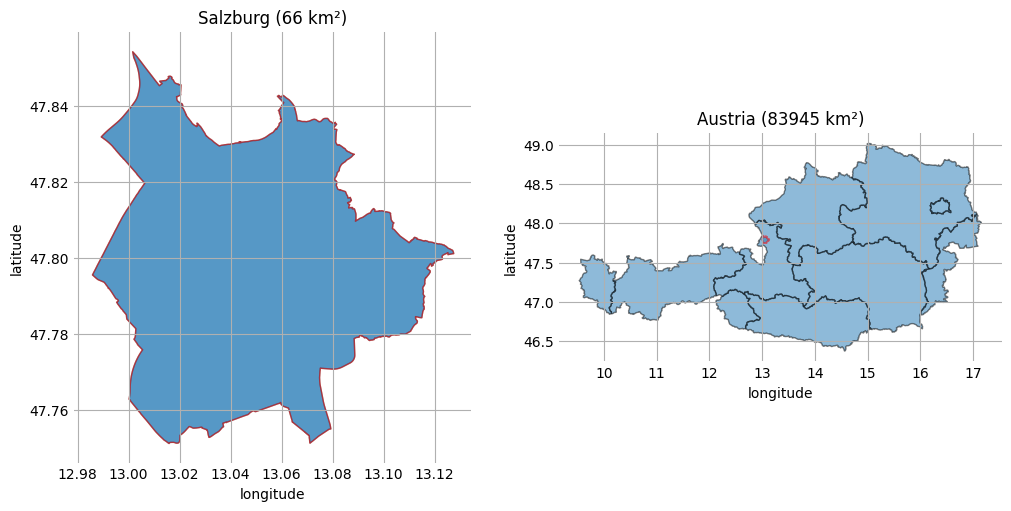

In [5]:
# read aois
at = gpd.read_file("files/austria.geojson")
sbg = gpd.read_file("files/sbg_city.geojson")

# plot aois
aois = {"Salzburg": sbg, "Austria": at}

fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
for i, (name,aoi) in enumerate(aois.items()):
    aoi_size = aoi.to_crs(3035).area.sum()/10**6
    aoi.to_crs(4326).plot(ax = axs[i], alpha=0.5, edgecolor="black")
    sbg.to_crs(4326).plot(ax = axs[i], alpha=0.5, edgecolor="red")
    axs[i].set_title(f"{name} ({aoi_size:.0f} km²)")
    axs[i].set_frame_on(False)
    axs[i].grid(True)
    axs[i].set_ylabel("latitude")
    axs[i].set_xlabel("longitude")
    axs[i].tick_params(length=0)

Let us define the basic spatio-temporal context for this part first.

In [6]:
# define spatio-temporal extent
res = 10
epsg = 3035
t_start, t_end = '2022-08-01', '2022-09-01'
time = sq.TemporalExtent(pd.Timestamp(t_start), pd.Timestamp(t_end))
aoi = sbg.to_crs(4326)
space = sq.SpatialExtent(aoi)

To create QueryRecipe for the cloudfree composite, we will define a function below that allows to change some essential parameters for the compositing easily. Depending on the specific arguments, a recipe will be created which outputs two relevant composites: The one called `comp_semantic` represents the model, where cloud-free pixels are explicitly queried. The `comp_median` represents the median composite for reference purposes. Have a close look at the following recipe and try to understand the differences in the composite creation.   

In [7]:
def model_cloudfree_composite(gran, bands = ["s2_band04", "s2_band03", "s2_band02"]):
    """Model to create cloud-free composites of defined temporal granularity
    
    params:
        gran: temporal granularity, one of ["year"], ["month"], ["season"], ["quarter"] or a combination 
        bands: list of bands to build the composite upon 
    
    notes:
        For the temporal granularity only disjunct/partionable combinations are feasible.
        E.g. ["year", "month"] can be used as granularity to get monthly cloudfree composites,
        whereas "season" doesn't work in conjunction with "year" as it spans several years.
    """ 

    recipe = sq.QueryRecipe()

    # 1. create basis composite as median of cloud-free images
    recipe["comp_semantic"] = (
        sq.collection(*[sq.layer(*x) for x in bands])
        .concatenate("band")
        .filter(sq.entity("cloud").evaluate("not"))
        .groupby_time(gran)
        .reduce("median", "time")
        .concatenate(gran[-1])
        .apply_custom("update_na")
        .apply_custom("change_dtype", dtype="float32")
    )

    # 2. create median composite for reference
    recipe["comp_median"] = (
        sq.collection(*[sq.layer(*x) for x in bands])
        .concatenate("band")
        .groupby_time(gran)
        .reduce("median", "time")
        .concatenate(gran[-1])
        .apply_custom("update_na")
        .apply_custom("change_dtype", dtype="float32")
    )

    return recipe

In [8]:
# define recipe
gran = "month"
bands = [
    ("Planet", "reflectance", "s2_band08"),
    ("Planet", "reflectance", "s2_band04"),
    ("Planet", "reflectance", "s2_band03"),
    ("Planet", "reflectance", "s2_band02"),
]

recipe = model_cloudfree_composite(gran, bands)

The recipe references the entity "cloud", so our corresponding mapping needs to contain at least this entity definition. For the specific data of interest, Sentinel-2, clouds can be defined based on the Scene Classification Layer as follows. 

In [9]:
# define mapping
mapping = sq.mapping.Semantique()
mapping["entity"] = {}
mapping["entity"]["cloud"] = {
    "color": sq.layer("Planet", "classification", "scl").evaluate("in", [8,9,10])
}

Finally, we need to define the datacube itself. To this end, we first perform a metadata search for the data that shall be ingested into the cube (given our previously defined spatio-temporal extent, recipe and mapping).

In [10]:
# search for data
fdr = Finder(ds_catalog, t_start, t_end, aoi.to_crs(4326).dissolve().geometry[0])

with open(layout_path, "r") as file:
    dc = sq.datacube.STACCube(json.load(file), src = [])

fdr.search_auto(
    recipe, 
    mapping, 
    dc, 
    custom_verbs={"update_na": update_na, "change_dtype": change_dtype}
)

The recipe references the following data layers:
('Planet', 'reflectance', 's2_band02')
('Planet', 'reflectance', 's2_band03')
('Planet', 'reflectance', 's2_band04')
('Planet', 'classification', 'scl')
('Planet', 'reflectance', 's2_band08')
Initialise search for ('Planet', 'reflectance', 's2_band02')
Search started
Search finished
Search postprocessed
Found 32 datasets
Initialise search for ('Planet', 'reflectance', 's2_band03')
Search started
Search finished
Search postprocessed
Found 32 datasets
Initialise search for ('Planet', 'reflectance', 's2_band04')
Search started
Search finished
Search postprocessed
Found 32 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 32 datasets
Initialise search for ('Planet', 'reflectance', 's2_band08')
Search started
Search finished
Search postprocessed
Found 32 datasets


In [11]:
# construct datacube
with open(layout_path, "r") as file:
    dc = sq.datacube.STACCube(
    json.load(file), 
    src = fdr.item_coll,
    group_by_solar_day = True,
    dask_params = None,
    )

Now, we have all pieces that are required to instantiate a TileHandler instance in order to run the model in a tiled manner.   

In [12]:
# create TileHandler instance & execute processing
out_dir = "results"
context = dict(
    recipe = recipe,
    datacube = dc,
    mapping = mapping,
    space = space,
    time = time,
    spatial_resolution = [-res, res],
    crs = epsg,
    chunksize_s = 1024,
    merge_mode = "merged",
    out_dir = out_dir,
    reauth = True,
    custom_verbs = {"update_na": update_na, "change_dtype": change_dtype}
)

if os.path.exists(out_dir):
    shutil.rmtree(out_dir)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    th = TileHandler(**context)
    th.execute()

creating spatial grid: 100%|██████████| 4/4 [00:00<00:00, 54.77it/s]


The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

-----------------------------------------
General layer info
-----------------------------------------
layer         : dtype     crs   res      
-----------------------------------------
n_images      : uint16    3035  [-10, 10]
comp_semantic : float32   3035  [-10, 10]
comp_median   : float32   3035  [-10, 10]
-----------------------------------------

----------------------------------------------------
Scenario: 'merge' = None
----------------------------------------------------
layer         :  size      tile n      tile shape   
----------------------------------------------------
n_images      : 0.03 Gb   4 tile(s)  (4, 1024, 1024)
comp_semantic : 0.06 Gb   4 tile(s)  (4, 1024, 1024)
comp_median  

executing recipe in tiled manner: 100%|██████████| 4/4 [00:57<00:00, 14.31s/it]


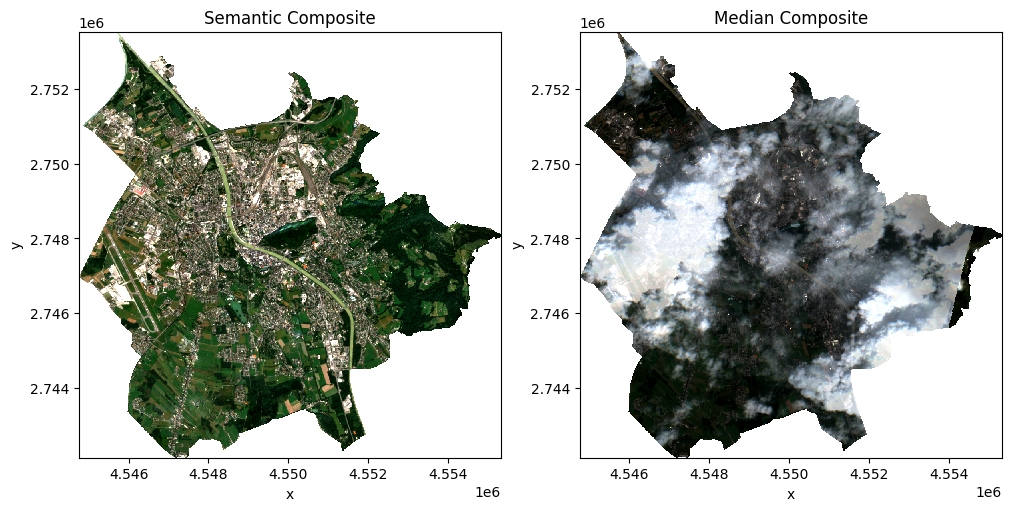

In [16]:
# plot & compare results
fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

comp_median = rxr.open_rasterio(os.path.join(out_dir, "comp_median.tif")).isel(band = [2,1,0])
comp_semantic = rxr.open_rasterio(os.path.join(out_dir, "comp_semantic.tif")).isel(band = [2,1,0])

comp_semantic.plot.imshow(ax = axs[0], robust=True)
comp_median.plot.imshow(ax = axs[1], robust=True)

axs[0].set_title("Semantic Composite")
axs[1].set_title("Median Composite");

Compare the two results and see the difference in remaining cloud coverage. The median composite can be further improved by prefiltering the scenes according to a maximum threshold of cloud coverage applied to the granule-wide metadata. However, the fundamental issue, that clouds may still be present in the composite created this way, remains.